## Import Libraries

In [74]:
from os import path, mkdir

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.nn.functional as F

import torchvision
import torchvision.models
import torchvision.transforms.v2 as transforms

import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [75]:
!nvidia-smi

Wed Sep  4 14:18:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0              7W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [76]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 4

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device(f"cuda:{DEVICE_NUM}")
print("INFO: Using device -", device)

INFO: Using device - cpu


## Load DataSets

In [77]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [78]:
# 데이터 전처리와 모델 설정을 위한 상수 정의
IMG_SIZE = (512, 512)
IMG_NORM = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
CLASS_LABELS = 11
DATA_ROOT = path.join(".", "data")

In [79]:
# 기본 변환: 이미지 리사이즈 및 정규화만 수행하는 변환 설정
basic_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # 이미지를 지정된 크기로 리사이즈
    transforms.ToImage(),  # 이미지를 PIL 또는 Tensor 형식으로 변환
    transforms.ToDtype(torch.float32, scale=True),  # 데이터를 float32로 변환하고 스케일을 맞춤
    transforms.Normalize(**IMG_NORM)  # 이미지 픽셀 값을 평균과 표준편차로 정규화
])

# 다양한 증강 기법을 적용한 변환 리스트 (각각에 기본 변환 포함)
augment_transforms = [
    transforms.Compose([transforms.AugMix(), basic_transform]),  # AugMix 증강 후 기본 변환 적용
    transforms.Compose([transforms.AutoAugment(), basic_transform])  # AutoAugment 증강 후 기본 변환 적용
]

In [80]:
# 기본적인 변환만 적용한 학습용 데이터셋 생성
original_train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=basic_transform)

# 커스텀 증강 기법을 적용한 학습용 데이터셋 생성
augmented_train_datasets = [
    FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=aug_transform) 
    for aug_transform in augment_transforms
]

# 기본 학습 데이터셋과 증강된 데이터셋을 하나의 데이터셋으로 결합
train_dataset = ConcatDataset([original_train_dataset] + augmented_train_datasets)

# 검증 및 테스트 데이터셋 생성 (기본 변환만 적용)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=basic_transform)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=basic_transform)

# 데이터셋 로드 성공 및 샘플 개수 출력
print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(39464), Valid(3430), Test(3347)


## DataLoader

In [81]:
# Set Batch Size
BATCH_SIZE = 16

In [82]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Using DataLoader without multi-processing.


## Define Model

### 0. ResNet With Attention

In [100]:
class Bottleneck(nn.Module):
    # Bottleneck 블록을 정의하는 클래스
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        # 초기화 함수: 입력 채널, 출력 채널, 스트라이드 및 다운샘플링 옵션을 설정
        super().__init__()

        # 1x1 컨볼루션: 입력 채널에서 출력 채널로의 변환. 스트라이드는 1, 바이어스는 사용하지 않음
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        
        # 첫 번째 배치 정규화: Conv1의 출력을 정규화
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3x3 컨볼루션: 중간 레이어, stride는 설정 가능하며, 출력은 동일한 채널 크기를 유지
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        
        # 두 번째 배치 정규화: Conv2의 출력을 정규화
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1x1 컨볼루션: 출력 채널 크기를 4배로 확장
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
        
        # 세 번째 배치 정규화: Conv3의 출력을 정규화
        self.bn3 = nn.BatchNorm2d(out_channels * 4)
    
        # 활성화 함수: ReLU를 사용하여 비선형성을 추가
        self.relu = nn.ReLU(inplace=True)
        
        # 다운샘플링: 입력 크기가 맞지 않을 때, identity 경로를 변환하기 위한 옵션
        self.downsample = downsample

    # Bottleneck 블록의 순전파 함수. 입력 x가 블록을 통과하는 방식 정의
    def forward(self, x):
        # Identity 저장: 입력을 따로 보존하여 이후에 더할 수 있도록 저장
        identity = x

        # 1x1 컨볼루션 -> 배치 정규화 -> ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 3x3 컨볼루션 -> 배치 정규화 -> ReLU
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 1x1 컨볼루션 -> 배치 정규화 (활성화 없음)
        out = self.conv3(out)
        out = self.bn3(out)

        # 다운샘플링이 있는 경우, 입력을 변환
        if self.downsample is not None:
            identity = self.downsample(x)

        # Bottleneck 블록의 출력에 identity 경로를 더함 (skip connection)
        out += identity
        
        # ReLU 활성화 적용
        out = self.relu(out)

        # 최종 출력 반환
        return out

In [101]:
class SelfAttention(nn.Module):
    # Self-Attention 모듈 정의. 입력 피처 맵의 중요한 위치에 집중하여 성능을 향상시킴
    def __init__(self, in_channels, reduction=8):
        # 초기화 함수: 입력 채널 크기와 채널 감소 비율 설정
        super().__init__()

        # Query 생성: 입력 채널을 reduction 비율로 줄인 1x1 컨볼루션
        self.query = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, stride=1)
    
        # Key 생성: 입력 채널을 reduction 비율로 줄인 1x1 컨볼루션
        self.key = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1, stride=1)
        
        # Value 생성: 입력 채널 크기를 그대로 유지하는 1x1 컨볼루션
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1)

    # 순전파 함수: Self-Attention 계산 방식 정의
    def forward(self, x):
        # 입력 텐서의 크기 (배치 크기, 채널, 너비, 높이) 추출
        batch_size, C, width, height = x.size()

        # Query 텐서 생성. (배치 크기, 새로운 채널 크기, 너비*높이)로 reshape 후 permute로 배치 차원 변경
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        
        # Key 텐서 생성. (배치 크기, 새로운 채널 크기, 너비*높이)로 reshape
        key = self.key(x).view(batch_size, -1, width * height)
        
        # Value 텐서 생성. (배치 크기, 기존 채널 크기, 너비*높이)로 reshape
        value = self.value(x).view(batch_size, -1, width * height)

        # Query와 Key의 행렬 곱으로 Attention 맵 생성 (배치 크기, 너비*높이, 너비*높이)
        attention = torch.bmm(query, key)
    
        # Attention 맵에 softmax 적용하여 각 위치의 중요도 계산
        attention = F.softmax(attention, dim=-1)

        # Value와 Attention 맵을 행렬 곱해 각 위치에 대한 값을 계산. (배치 크기, 기존 채널 크기, 너비*높이)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        
        # 출력 텐서를 원래 크기 (배치 크기, 채널, 너비, 높이)로 reshape
        out = out.view(batch_size, C, width, height)

        # 원래 입력 값과 계산된 값을 더해 최종 출력 반환 (skip connection)
        return out + x

In [102]:
class ResNetA(nn.Module):
    # ResNetA 모델 정의: ResNet 구조를 기반으로 Self-Attention 추가
    def __init__(self, num_classes=11):
        # 초기화 함수: ResNetA 클래스의 기본 구성 요소 설정
        super().__init__()

        # ResNet 기반 네트워크 정의 (Sequential로 레이어 구성)
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),  # 7x7 커널, 2 스트라이드
            nn.BatchNorm2d(64),  # Batch Normalization
            nn.ReLU(inplace=True),  # 활성화 함수 ReLU
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # Max pooling
            self._make_layer(64, 64, layers=3),  # 첫 번째 레이어 (3개의 Bottleneck 블록)
            self._make_layer(256, 128, layers=4, stride=2),  # 두 번째 레이어 (4개의 Bottleneck 블록)
            self._make_layer(512, 256, layers=6, stride=2),  # 세 번째 레이어 (6개의 Bottleneck 블록)
            self._make_layer(1024, 512, layers=3, stride=2),  # 네 번째 레이어 (3개의 Bottleneck 블록)
        )

        # Self-Attention 레이어 추가 (2048 채널 입력)
        self.attention = SelfAttention(2048)

        # Adaptive 평균 풀링 레이어 (출력 크기: 1x1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        # 첫 번째 Fully Connected 레이어 (2048 입력, 512 출력)
        self.fc1 = nn.Linear(2048, 512)

        # ReLU 활성화 함수
        self.relu = nn.ReLU()

        # Dropout 레이어 (드롭 확률 50%)
        self.dropout = nn.Dropout(p=0.5)

        # 두 번째 Fully Connected 레이어 (512 입력, 클래스 개수 출력)
        self.fc2 = nn.Linear(512, num_classes)

    # ResNet의 레이어를 만드는 함수 (Bottleneck 블록으로 구성)
    def _make_layer(self, in_channels, out_channels, layers, stride=1):
        downsample = None
        # 다운샘플링이 필요할 때, 채널 크기와 스트라이드에 맞게 조정
        if stride != 1 or in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        # Bottleneck 블록들을 쌓아 레이어 구성
        blocks = []
        blocks.append(Bottleneck(in_channels, out_channels, stride, downsample))  # 첫 번째 Bottleneck
        for _ in range(1, layers):
            blocks.append(Bottleneck(out_channels * 4, out_channels))  # 추가 Bottleneck 블록들

        return nn.Sequential(*blocks)

    # 순전파 함수 (입력 데이터가 모델을 통과하는 과정 정의)
    def forward(self, x):
        x = self.resnet(x)  # ResNet 블록을 통과
        x = self.attention(x)  # Self-Attention 적용
        x = self.avg_pool(x)  # 평균 풀링 적용
        x = torch.flatten(x, 1)  # 텐서 평탄화 (Fully Connected 레이어로 넘기기 위해)
        x = self.fc1(x)  # 첫 번째 FC 레이어 통과
        x = self.relu(x)  # 활성화 함수 적용
        x = self.dropout(x)  # Dropout 적용
        x = self.fc2(x)  # 두 번째 FC 레이어 통과 (출력: 클래스 예측 값)
        return x  # 최종 출력

### Initialize Model

In [103]:
model = ResNetA(num_classes=CLASS_LABELS)

# 저장된 모델을 불러오고 싶으면 True로 설정
load_model = True

# 모델 ID와 저장된 모델 정보
model_id = "ResNetA101"
model_info = ""

# 만약 load_model이 True라면 저장된 가중치를 모델에 로드
if load_model:
    # 저장된 모델 가중치 불러오기
    state_dict = torch.load(path.join(".", "models", f"{model_info}.pt"))
    
    try:    
        # DataParallel을 사용하지 않은 모델을 그대로 불러올 때
        model.load_state_dict(state_dict)
    except:
        # DataParallel로 학습된 모델을 로드할 때 발생하는 'module.' 접두사 문제 해결
        # 'module.' 접두사가 있는 경우, 이를 제거한 후에 다시 로드
        new_state_dict = dict()
        for k, v in state_dict.items():
            name = k[7:]  # 'module.' 접두사 제거
            new_state_dict[name] = v
        state_dict = new_state_dict
        # 수정된 가중치를 모델에 로드
        model.load_state_dict(new_state_dict)

model.to(device)

ResNetA(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [87]:
# 손실 함수와 optimizer 설정 
LEARNING_RATE = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

## Training Loop

In [88]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [105]:
def save_model(model_id: str, acc: float, loss: float, epoch: int | None = None) -> None:
    # 에포크가 주어졌으면 backup 디렉토리, 그렇지 않으면 models 디렉토리에 저장
    dir_path: str = path.join(".", "models", "backup") if epoch else path.join(".", "models")
    
    # 저장할 경로가 없으면 디렉토리 생성
    if not path.isdir(dir_path):
        mkdir(dir_path)
    
    # 에포크 정보가 있으면 에포크 번호 포함한 모델 이름 생성
    if epoch:
        model_info: str = f"{epoch:02}__{model_id}__acc__{acc:.6f}__loss__{loss:.6f}"
    else:
        # 에포크 정보가 없을 때는 에포크 없이 모델 이름 생성
        model_info = f"{model_id}__acc__{acc:.6f}__loss__{loss:.6f}"
    
    # 최종 저장 경로 생성
    save_path: str = path.join(dir_path, f"{model_info}.pt")
    
    # 모델의 가중치를 해당 경로에 저장
    torch.save(model.state_dict(), save_path)
    
    # 에포크 정보가 없을 경우 저장 완료 메시지 출력
    if not epoch:
        print(f"Model saved to {save_path}")

In [90]:
# 에포크 수 설정
num_epochs = 50

# 데이터 증강 - CutMix 및 MixUp 설정
# CutMix는 이미지의 일부를 잘라서 다른 이미지와 결합하는 데이터 증강 기법
cutmix = transforms.CutMix(num_classes=11)

# MixUp은 두 이미지의 픽셀 값을 가중 평균하는 데이터 증강 기법
mixup = transforms.MixUp(num_classes=11)

# CutMix와 MixUp 중 무작위로 하나를 선택하는 증강 기법
cutmix_or_mixup = transforms.RandomChoice([cutmix, mixup])

In [91]:
# 멀티 GPU 사용 설정
# nn.DataParallel을 사용하여 모델을 여러 GPU에서 병렬로 학습할 수 있도록 설정
# 'device_ids' 리스트에 원하는 GPU의 ID를 지정 (여기서는 4번, 5번 GPU 사용)
model = nn.DataParallel(module=model, device_ids=[4, 5])

Running Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/2467 [00:00<?, ?it/s]

Validation:   0%|          | 0/215 [00:00<?, ?it/s]

Output()

KeyboardInterrupt: 

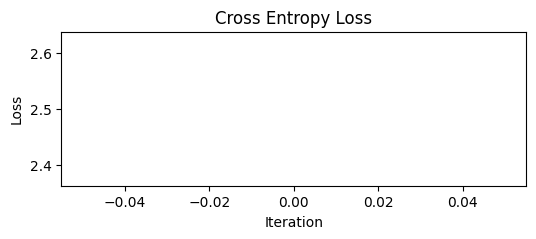

In [92]:
# 학습 및 검증 데이터 길이를 측정하고, 증강 확률을 설정
train_length, valid_length = map(len, (train_loader, valid_loader))
aug_prob = 0.666  # CutMix 또는 MixUp을 적용할 확률

# tqdm을 사용하여 학습 진행 상황을 시각적으로 표시
epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,  # 학습 진행 바
      tqdm(total=valid_length, desc="Validation") as valid_progress):  # 검증 진행 바

    update = create_plot()  # 손실 함수 변화를 시각화할 그래프 생성

    for epoch in epochs:
        train_progress.reset(total=train_length)  # 학습 진행 바 초기화
        valid_progress.reset(total=valid_length)  # 검증 진행 바 초기화

        # 학습 모드로 전환
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()  # 옵티마이저 초기화

            # 데이터의 일부에 CutMix 또는 MixUp 적용
            if torch.rand(1).item() < aug_prob:
                inputs, targets = cutmix_or_mixup(inputs, targets)

            # 데이터를 GPU 장치로 이동
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # 모델을 통해 출력 계산

            loss = criterion(outputs, targets)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 옵티마이저 스텝 수행

            update(loss)  # 손실 업데이트
            train_progress.update(1)  # 학습 진행 바 업데이트

        val_acc, val_loss = 0, 0  # 검증 정확도 및 손실 초기화

        # 검증 모드로 전환
        model.eval()
        with torch.no_grad():  # 검증 중에는 그래디언트 계산을 하지 않음
            for i, (inputs, targets) in enumerate(valid_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                # 검증 손실 및 정확도 계산
                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)  # 검증 진행 바 업데이트

        # Epoch 끝난 후 결과 출력 및 저장
        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")
        save_model(model_id=model_id, acc=val_acc, loss=val_loss, epoch=epoch+1)  # 모델 저장

## Weights Save

In [106]:
# 모델 저장 함수 호출 시 모델 ID, 검증 정확도 및 손실 값 전달
save_model(model_id=model_id, acc=val_acc, loss=val_loss)

# 모델 저장 시 파일 이름에 검증 정확도 정보 포함
model_info = f"{model_id}__acc__{val_acc:.6f}"

Model saved to .\models\ResNetA101__acc__0.685000__loss__1.300000.pt


# Model Evaluation

In [99]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

# train_dataset에서 'classes' 속성을 얻기 위해 첫 번째 데이터셋 참조
train_classes = train_dataset.datasets[0].classes

# test_dataset에서 'classes' 속성을 반복 밖에서 얻음
test_classes = test_dataset.classes

model.to(device)
model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # 각 id와 예측된 라벨을 results에 추가
        results['id'] += [test_classes[i] for i in ids]
        results['label'] += [train_classes[i] for i in preds.cpu().tolist()]


  0%|          | 0/210 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
results_df = pd.DataFrame(results)

# 제출 디렉토리가 존재하지 않으면 디렉토리 생성
submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

# 제출 파일 경로 설정 (모델 정보와 함께 파일명 생성)
submit_file_path = path.join(submission_dir, f"{model_info}.csv")

# 결과를 CSV 파일로 저장 (인덱스 없이 저장)
results_df.to_csv(submit_file_path, index=False)

print("File saved to", submit_file_path)

results_df.head()

File saved to submissions/02__ResNetA101__acc__0.873178__loss__0.457942.csv


,id,label
0,TEST_0000,Dessert
1,TEST_0001,Dairy product
2,TEST_0002,Soup
3,TEST_0003,Meat
4,TEST_0004,Fried food
